# Import libraries

In [ ]:
# general stuff
import gdown
import numpy as np
import pandas as pd
import time

# data cleaning and preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC

# classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# metrics
from sklearn.metrics import accuracy_score, recall_score, precision_recall_fscore_support, confusion_matrix, make_scorer

# training and cross-validation
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, validation_curve

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
class ScalarFormatterForceFormat(ScalarFormatter):
    def _set_format(self):  # Override function that finds format to use.
        self.format = "%1.1f"  # Give format here

# 1. Exploratory data analysis

In [ ]:
# download drug consumption dataset
!gdown 'https://drive.google.com/uc?id=1D4VA6sgiLSOEHzYqYwNKVwXabWLdwkpZ' -O ./drug_consumption.data
ds = pd.read_csv('drug_consumption.data', header=None)
ds

Downloading...
From: https://drive.google.com/uc?id=1D4VA6sgiLSOEHzYqYwNKVwXabWLdwkpZ
To: /content/drug_consumption.data
100% 347k/347k [00:00<00:00, 103MB/s]


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
1,2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
2,3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
3,4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
4,5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880,1884,-0.95197,0.48246,-0.61113,-0.57009,-0.31685,-1.19430,1.74091,1.88511,0.76096,...,CL0,CL0,CL0,CL3,CL3,CL0,CL0,CL0,CL0,CL5
1881,1885,-0.95197,-0.48246,-0.61113,-0.57009,-0.31685,-0.24649,1.74091,0.58331,0.76096,...,CL2,CL0,CL0,CL3,CL5,CL4,CL4,CL5,CL0,CL0
1882,1886,-0.07854,0.48246,0.45468,-0.57009,-0.31685,1.13281,-1.37639,-1.27553,-1.77200,...,CL4,CL0,CL2,CL0,CL2,CL0,CL2,CL6,CL0,CL0
1883,1887,-0.95197,0.48246,-0.61113,-0.57009,-0.31685,0.91093,-1.92173,0.29338,-1.62090,...,CL3,CL0,CL0,CL3,CL3,CL0,CL3,CL4,CL0,CL0


## Data cleaning

In [ ]:
### data cleaning

# add column names
columns = [# demographic features
           'ID',
           'Age',
           'Gender',
           'Education', 
           'Country',
           'Ethnicity',
           # personality features
           'N_score',    # Neuroticism
           'E_score',    # Extraversion
           'O_score',    # Openness to experience
           'A_score',    # Agreeableness
           'C_score',    # Conscientiousness
           'I_score',    # Impulsiveness
           'S_score'    # Sensation seeking
           ]

drugs = [# drug consumption features
         'alcohol',
         'amphetamines',
         'amyl_nitrite',
         'benzodiazepine',
         'caffeine',
         'cannabis',
         'chocolate',
         'cocaine',
         'crack',
         'ecstasy',
         'heroin',
         'ketamine',
         'legal_highs',
         'lsd',
         'methadone',
         'mushrooms',
         'nicotine',
         'semeron',
         'vsa'
         ]

columns += drugs

drugs_legal = ['alcohol', 'caffeine', 'chocolate', 'nicotine']
drugs_illegal = [d for d in drugs if d not in drugs_legal]

ds.columns = columns


# map consumption (categorical) features to numerical values
consumption_cat2num = {'CL0':0, 'CL1':1, 'CL2':2, 'CL3':3, 'CL4':4, 'CL5':5, 'CL6':6}
ds[drugs] = ds[drugs].applymap(lambda val: consumption_cat2num[val], na_action='ignore')

# drop ID column
ds = ds.drop(columns='ID', errors='ignore')

# map demographic features to numerical values
age_enc = OrdinalEncoder()
ds['Age'] = pd.Series(age_enc.fit_transform(ds['Age'].values.reshape(-1,1)).reshape(-1))

gender_enc = OrdinalEncoder()
ds['Gender'] = pd.Series(gender_enc.fit_transform(ds['Gender'].values.reshape(-1,1)).reshape(-1))   # 1: female, 0: male

education_enc = OrdinalEncoder()
ds['Education'] = pd.Series(education_enc.fit_transform(ds['Education'].values.reshape(-1,1)).reshape(-1))

# we could one-hot-encode nominal demographic features (country, ethnicity) to numerical values,
# but for a number of reasons I decide to just drop them. Reasons:
# 1: We want to be able to infere for people from any country and any ethnicity (avoid discrimination!)
# 2: One-hot-encoding nominal features with a high-cardinality domain worsens curse of dimensionality
# 3: Features are very biased towards white people from USA and UK
# this last point is verified hereafter:
print("The first two values are the fraction of samples from UK and USA respectively")
print(ds['Country'].value_counts() / ds['Country'].value_counts().sum())
print("The first value is the fraction of samples who are white")
print(ds['Ethnicity'].value_counts() / ds['Ethnicity'].value_counts().sum())
ds = ds.drop(columns=['Country','Ethnicity'], errors='ignore')

# drop semeron users (=overclaimers)
ds = ds.drop(index=ds[ds['semeron']>0].index, errors='ignore')
ds = ds.drop(columns='semeron', errors='ignore')
try:
    drugs.remove('semeron')
    drugs_illegal.remove('semeron')
except ValueError:
    pass  # already removed

# reset row index
ds = ds.reset_index(drop=True)

The first two values are the fraction of samples from UK and USA respectively
 0.96082    0.553846
-0.57009    0.295491
-0.28519    0.062599
 0.24923    0.046154
-0.09765    0.028647
 0.21128    0.010610
-0.46841    0.002653
Name: Country, dtype: float64
The first value is the fraction of samples who are white
-0.31685    0.912467
 0.11440    0.033422
-1.10702    0.017507
-0.50212    0.013793
 0.12600    0.010610
-0.22166    0.010610
 1.90725    0.001592
Name: Ethnicity, dtype: float64


In [ ]:
# missing values
print(ds.info())
# there are no missing values

# statistical descriptors of the dataset
ds.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1877 entries, 0 to 1876
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             1877 non-null   float64
 1   Gender          1877 non-null   float64
 2   Education       1877 non-null   float64
 3   N_score         1877 non-null   float64
 4   E_score         1877 non-null   float64
 5   O_score         1877 non-null   float64
 6   A_score         1877 non-null   float64
 7   C_score         1877 non-null   float64
 8   I_score         1877 non-null   float64
 9   S_score         1877 non-null   float64
 10  alcohol         1877 non-null   int64  
 11  amphetamines    1877 non-null   int64  
 12  amyl_nitrite    1877 non-null   int64  
 13  benzodiazepine  1877 non-null   int64  
 14  caffeine        1877 non-null   int64  
 15  cannabis        1877 non-null   int64  
 16  chocolate       1877 non-null   int64  
 17  cocaine         1877 non-null   i

,Age,Gender,Education,N_score,E_score,O_score,A_score,C_score,I_score,S_score,...,crack,ecstasy,heroin,ketamine,legal_highs,lsd,methadone,mushrooms,nicotine,vsa
count,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,...,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000
mean,1.350027,0.499201,4.995205,-0.000551,-0.001951,-0.003224,-0.000657,-0.000394,0.005293,-0.007408,...,0.295685,1.309536,0.372403,0.564198,1.353223,1.053277,0.826319,1.177944,3.194992,0.429409
std,1.277790,0.500133,1.764214,0.998442,0.997418,0.995691,0.996689,0.997657,0.954148,0.962074,...,0.835925,1.647373,1.034761,1.216341,1.790881,1.484582,1.648379,1.459212,2.415814,0.959160
min,0.000000,0.000000,0.000000,-3.464360,-3.273930,-3.273930,-3.464360,-3.464360,-2.555240,-2.078480,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,4.000000,-0.678250,-0.695090,-0.717270,-0.606330,-0.652530,-0.711260,-0.525930,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,1.000000,0.000000,5.000000,0.042570,0.003320,-0.019280,-0.017290,-0.006650,-0.217120,0.079870,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
75%,2.000000,1.000000,6.000000,0.629670,0.637790,0.723300,0.760960,0.584890,0.529750,0.765400,...,0.000000,3.000000,0.000000,0.000000,3.000000,2.000000,0.000000,2.000000,6.000000,0.000000
max,5.000000,1.000000,8.000000,3.273930,3.273930,2.901610,3.464360,3.464360,2.901610,1.921730,...,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000


One can design and try to solve various binary classification problems on this dataset. Examples:
*  **Users vs non-users/legal users**
*   Specific drug users vs non-users
*   ...

I chose to focus on the first one

In [ ]:
# I consider a person a "drug user" (1) if he/she consumed any illegal drug in the last year
mask_users = (ds.loc[:,drugs_illegal] >= 3).any(axis=1)     # with 4 or 5 is more balanced

X = ds[['Age','Gender','Education','N_score','E_score','O_score','A_score','C_score','I_score','S_score']]
y = mask_users.astype(int)

In [ ]:
# some feature rearrangements for human understandability

age = ['18-24' if a == 0 else 
       '25-34' if a == 1 else 
       '35-44' if a == 2 else 
       '45-54' if a == 3 else 
       '55-64' if a == 4 else 
       '65+'
       for a in ds['Age']]
age_order = ['18-24','25-34','35-44','45-54','55-64','65+']

gender = ['Female' if g == 1 else "Male" for g in ds['Gender']]
gender_order = ['Male','Female']    # no sexism intended!

education = ['Left school before 16 years' if e == 0 else 
             'Left school at 16 years' if e == 1 else 
             'Left school at 17 years' if e == 2 else 
             'Left school at 18 years' if e == 3 else 
             'Some college or university, no certificate or degree' if e == 4 else 
             'Professional certificate/diploma' if e == 5 else 
             'University degree' if e == 6 else 
             'Masters degree' if e == 7 else 
             'Doctorate degree' 
             for e in ds['Education']]
education_order = ['Left school before 16 years',
                   'Left school at 16 years',
                   'Left school at 17 years',
                   'Left school at 18 years',
                   'Some college or university, no certificate or degree',
                   'Professional certificate/diploma',
                   'University degree',
                   'Masters degree',
                   'Doctorate degree']

X_understandable = X.copy()
X_understandable['Age'] = age
X_understandable['Gender'] = gender
X_understandable['Education'] = education

y_understandable = pd.Series(['Not user' if l == 0 else 'User' for l in y])

## Visualize distributions

Label distribution
Not user     706
User        1171
dtype: int64


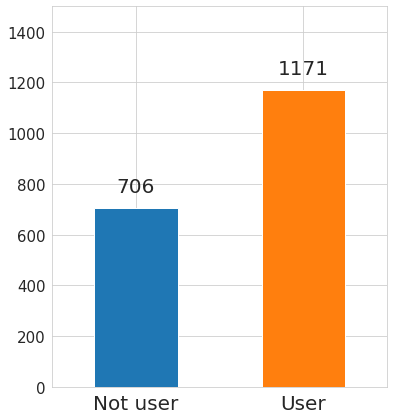

In [ ]:
# label distribution
print("Label distribution")
y_counts = y_understandable.value_counts(ascending=True)
print(y_counts)

# label distribution (count plot)
fig, ax = plt.subplots(figsize=(6,7))
ax = y_counts.plot(kind='bar', color=['C0','C1'])
#ax.set_xticklabels(['Not user', 'User'], fontdict={'rotation':0,'fontsize':20})
plt.setp(ax.get_xticklabels(), fontsize=20, rotation=0)
ax.tick_params(axis='y', labelsize=15)
ax.set_ylim(top=1500)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()+p.get_width()/2, p.get_height()+60), horizontalalignment='center', fontsize=20)

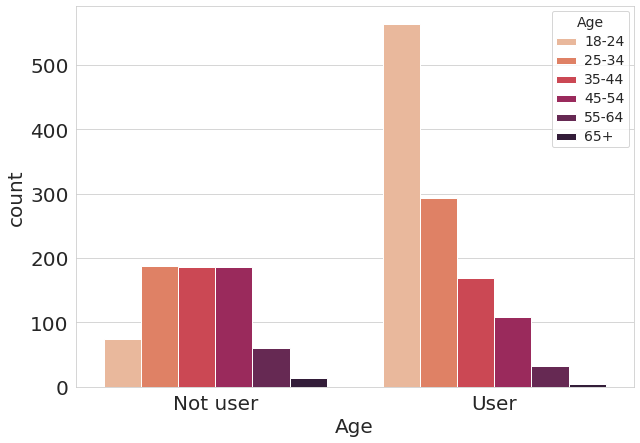

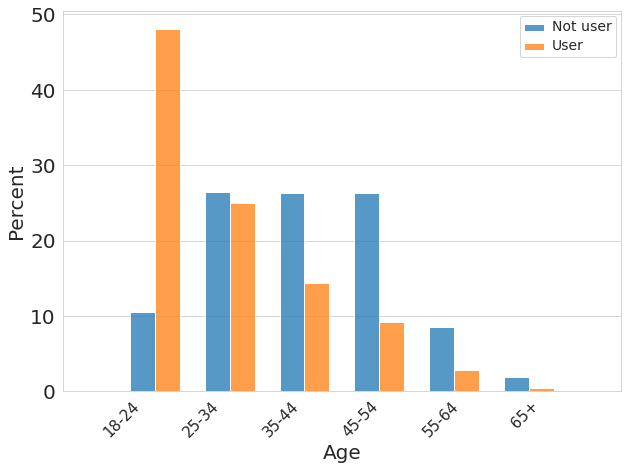

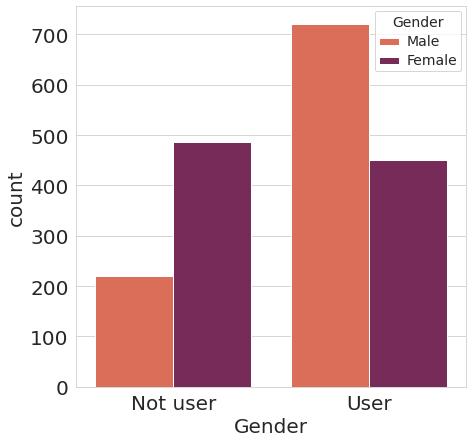

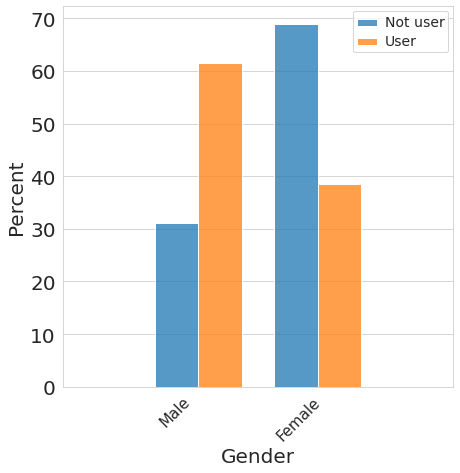

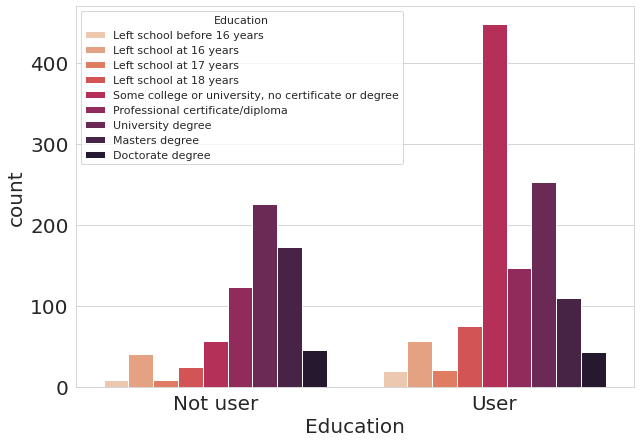

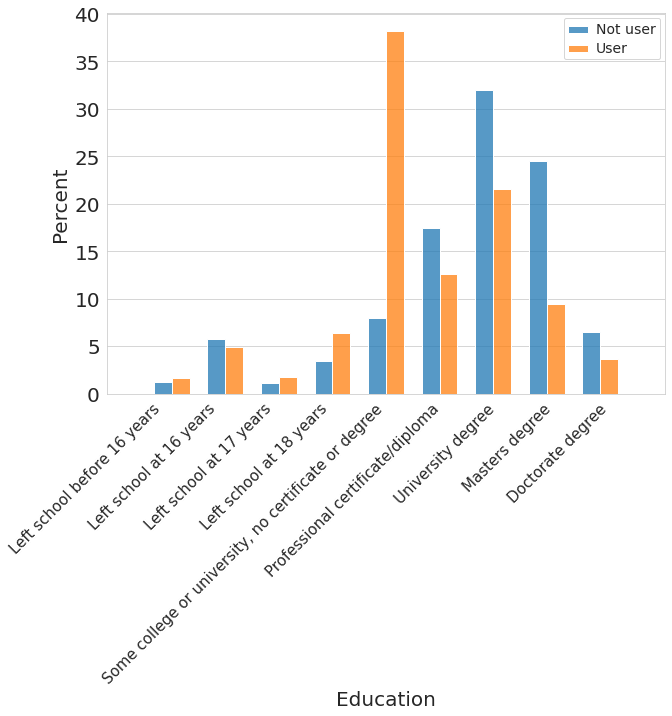

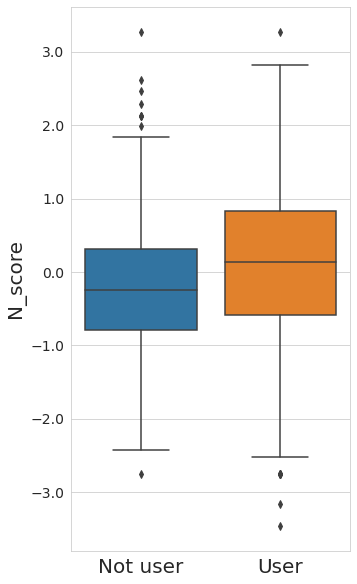

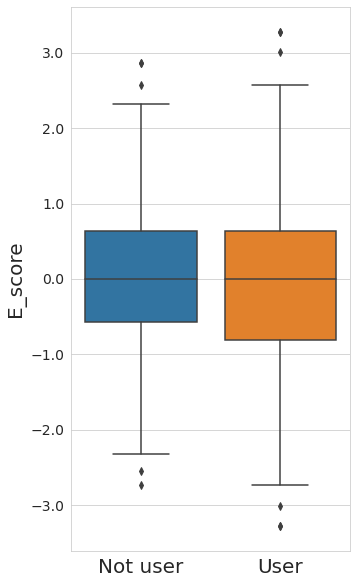

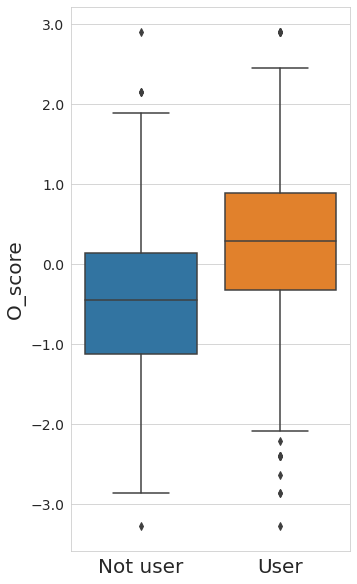

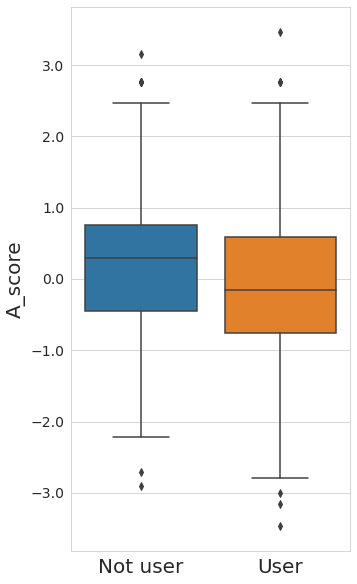

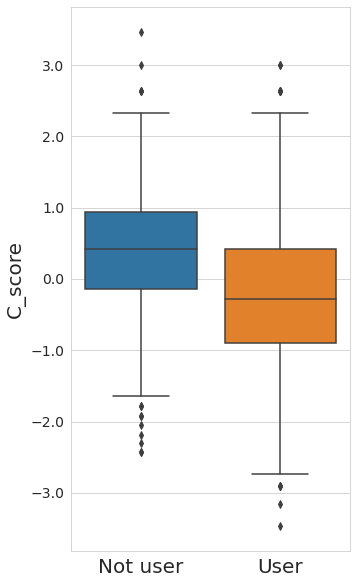

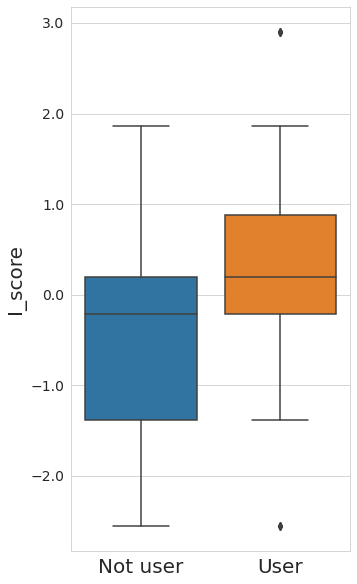

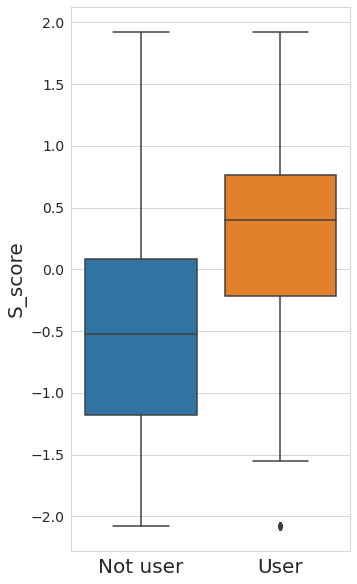

In [ ]:
### features distribution

sns.set_style("whitegrid")
# age countplot
fig, ax = plt.subplots(figsize=(10,7))
ax = sns.countplot(x=y_understandable, hue='Age', hue_order=age_order, data=X_understandable, palette=sns.color_palette('rocket_r', n_colors=len(age_order)))
plt.setp(ax.get_xticklabels(), fontsize=20)
plt.setp(ax.get_yticklabels(), fontsize=20)
ax.set_xlabel('Age')
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.setp(ax.get_legend().get_texts(), fontsize='14')
plt.setp(ax.get_legend().get_title(), fontsize='14')
# age frequency histogram
fig, ax = plt.subplots(figsize=(10,7))
ax = sns.histplot(x='Age', hue=y_understandable, data=X, stat="percent", common_norm=False, multiple="dodge", shrink=2)
plt.xticks(ticks=range(0,len(age_order)+1), labels=age_order)
plt.setp(ax.get_xticklabels(), fontsize=15, rotation=45, ha='right')
plt.setp(ax.get_yticklabels(), fontsize=20)
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.xaxis.grid(False)
ax.set_xlim(-1,len(age_order))
plt.setp(ax.get_legend().get_texts(), fontsize='14')
plt.setp(ax.get_legend().get_title(), fontsize='14')

# gender countplot
fig, ax = plt.subplots(figsize=(7,7))
ax = sns.countplot(x=y_understandable, hue='Gender', hue_order=gender_order, data=X_understandable, palette=sns.color_palette('rocket_r', n_colors=len(gender_order)))
plt.setp(ax.get_xticklabels(), fontsize=20)
plt.setp(ax.get_yticklabels(), fontsize=20)
ax.set_xlabel('Gender')
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.setp(ax.get_legend().get_texts(), fontsize='14')
plt.setp(ax.get_legend().get_title(), fontsize='14')
# gender frequency histogram
fig, ax = plt.subplots(figsize=(7,7))
ax = sns.histplot(x='Gender', hue=y_understandable, data=X, stat="percent", common_norm=False, multiple="dodge", shrink=8)
plt.xticks(ticks=range(0,len(gender_order)+1), labels=gender_order)
plt.setp(ax.get_xticklabels(), fontsize=15, rotation=45, ha='right')
plt.setp(ax.get_yticklabels(), fontsize=20)
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.xaxis.grid(False)
ax.set_xlim(-1,len(gender_order))
plt.setp(ax.get_legend().get_texts(), fontsize='14')
plt.setp(ax.get_legend().get_title(), fontsize='14')

# education countplot
fig, ax = plt.subplots(figsize=(10,7))
ax = sns.countplot(x=y_understandable, hue='Education', hue_order=education_order, data=X_understandable, palette=sns.color_palette('rocket_r', n_colors=len(education_order)))
plt.setp(ax.get_xticklabels(), fontsize=20)
plt.setp(ax.get_yticklabels(), fontsize=20)
ax.set_xlabel('Education')
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
plt.setp(ax.get_legend().get_texts(), fontsize='11')
plt.setp(ax.get_legend().get_title(), fontsize='11')
# education frequency histogram
fig, ax = plt.subplots(figsize=(10,7))
ax = sns.histplot(x='Education', hue=y_understandable, data=X, stat="percent", common_norm=False, multiple="dodge", shrink=2)
plt.xticks(ticks=range(0,len(education_order)+1), labels=education_order)
plt.setp(ax.get_xticklabels(), fontsize=15, rotation=45, ha='right')
plt.setp(ax.get_yticklabels(), fontsize=20)
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.xaxis.grid(False)
ax.set_xlim(-1,len(education_order))
plt.setp(ax.get_legend().get_texts(), fontsize='14')
plt.setp(ax.get_legend().get_title(), fontsize='14')


# boxplots (for numerical attributes)
def plot_boxplots(X, y, exceptions=[]):
    columns = [c for c in X.columns if c not in exceptions]
    for i, c in enumerate(columns):
        fig, ax = plt.subplots(figsize=(5,10))
        ax = sns.boxplot(x=y, y=c, data=X, ax=ax)
        ax.set_xticklabels(ax.get_xticklabels(), fontdict={'rotation':0,'fontsize':20})
        ax.yaxis.label.set_size(20)
        ax.tick_params(axis='y', labelsize=14)
        yfmt = ScalarFormatterForceFormat()
        #yfmt.set_powerlimits((0,0))
        ax.yaxis.set_major_formatter(yfmt)
        
plot_boxplots(X_understandable, y_understandable, exceptions=['Age','Education','Gender'])

## Check feature correlation

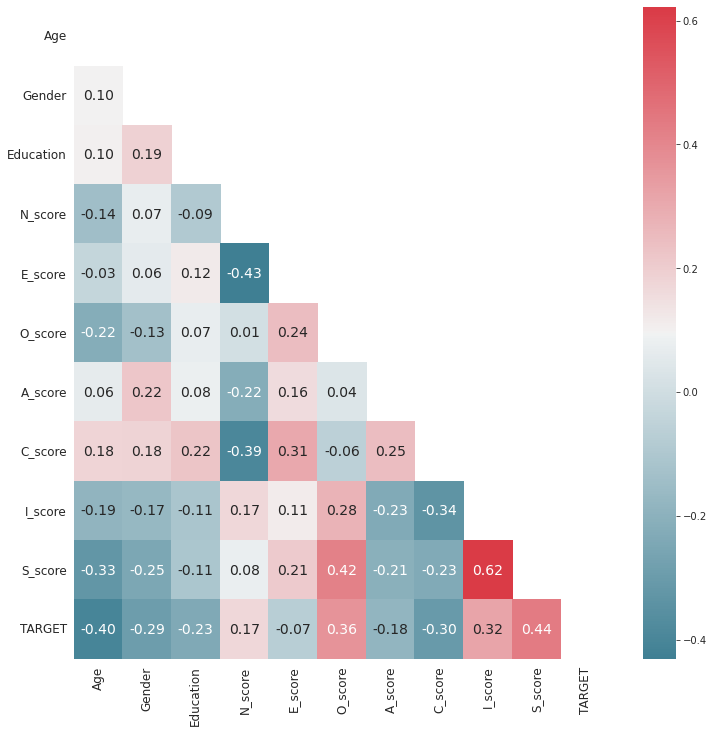

In [ ]:
# features correlation
# NB: the formula of Pearson's correlation coefficient implicitly make use of standardized data,
# so no need to standardize beforehand!

X_y = X.copy()
X_y['TARGET'] = y
corr_matrix = X_y.corr()

plt.figure(figsize=(12, 12))
dropSelf = np.zeros_like(corr_matrix)
dropSelf[np.triu_indices_from(dropSelf)] = True
hm = sns.heatmap(corr_matrix, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", annot_kws={"size":14}, mask=dropSelf)
hm.set_xticklabels(hm.get_xticklabels(), size = 12, rotation = 90)
hm.set_yticklabels(hm.get_yticklabels(), size = 12, rotation = 0)
plt.show()

# no strong correlations between predictors, so no predictors to remove
# moreover, no strong correlation between predictors and target variable

# feature selection
print('---- feature selection ----')
# remove highly correlated features (keep only one of those highly correlated)
corr_matrix = X.corr()
tril_corr_matrix = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1) == 1)
columns_to_drop = tril_corr_matrix.columns[(tril_corr_matrix.abs() > 0.8).any()]
if len(columns_to_drop) == 0:
    print('NO CORRELATED PREDICTORS TO DROP!\n')
else:
    X_fs = X.drop(columns=columns_to_drop, errors='ignore')
    print(f'Dropped predictors: {columns_to_drop}\n')

    # plot the new correlation matrix as a heatmap
    corr_matrix = X_fs.corr()

    plt.figure(figsize=(12, 12))
    dropSelf = np.zeros_like(corr_matrix)
    dropSelf[np.triu_indices_from(dropSelf)] = True

    hm = sns.heatmap(corr_matrix, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", annot_kws={"size":14}, mask=dropSelf)
    hm.set_xticklabels(hm.get_xticklabels(), size = 12, rotation = 90)
    hm.set_yticklabels(hm.get_yticklabels(), size = 12, rotation = 0)
    plt.show()

## PCA

---- feature selection ----
NO CORRELATED PREDICTORS TO DROP!

---- standardization ----
                Age        Gender     Education       N_score       E_score  \
count  1.877000e+03  1.877000e+03  1.877000e+03  1.877000e+03  1.877000e+03   
mean   4.306033e-15  7.718919e-17 -2.143553e-16  4.924138e-17 -1.665630e-16   
std    1.000266e+00  1.000266e+00  1.000266e+00  1.000266e+00  1.000266e+00   
min   -1.056814e+00 -9.984030e-01 -2.832160e+00 -3.470137e+00 -3.281325e+00   
25%   -1.056814e+00 -9.984030e-01 -5.642572e-01 -6.789367e-01 -6.951186e-01   
50%   -2.740043e-01 -9.984030e-01  2.718584e-03  4.320015e-02  5.286319e-03   
75%    5.088056e-01  1.001600e+00  5.696944e-01  6.313727e-01  6.415686e-01   
max    2.857235e+00  1.001600e+00  1.703646e+00  3.280464e+00  3.285238e+00   

            O_score       A_score       C_score       I_score       S_score  
count  1.877000e+03  1.877000e+03  1.877000e+03  1.877000e+03  1.877000e+03  
mean  -6.383339e-16  1.852540e-16 -4.113503

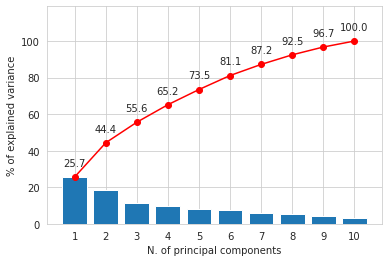

In [ ]:
# standardization
print('---- standardization ----')
standard_scaler = StandardScaler().fit(X)
X_standardized = standard_scaler.transform(X)
X_standardized = pd.DataFrame(X_standardized, columns=X.columns)
print(X_standardized.describe())
print()

# PCA
print('---- PCA ----')
def display_scree_plot(pca):
    '''Display a scree plot for the pca'''
    expl_var_percentage = pca.explained_variance_ratio_*100   # y1
    cum_expl_var_percentage = expl_var_percentage.cumsum()     # y2
    x = np.arange(len(expl_var_percentage))+1
    plt.bar(x, expl_var_percentage)
    plt.plot(x, cum_expl_var_percentage, c="red", marker='o')
    plt.xticks(x)
    plt.xlabel("N. of principal components")
    plt.ylabel("% of explained variance")
    for i, txt in enumerate(cum_expl_var_percentage):
        plt.annotate(f'{txt:.1f}', (x[i], cum_expl_var_percentage[i]+6), horizontalalignment='center')
    plt.ylim(0,119)
    
pca = PCA().fit(X_standardized)     # n_components = len(X.columns)
display_scree_plot(pca)

# with 6 components we have more than 80% of explained variance

# 3. Classification Models

NB: X is the result of the data cleaning steps; any preprocessing performed so far was only for EDA reasons.

To avoid data leakage, preprocessing steps (outliers removal, correlation analysis+feature selection, **standardization**, **pca+feature reduction**, **rebalancing**) must be fit ONLY ON THE CURRENT K-1 TRAINING FOLDS during cross validation, and then transform the validation fold accordingly.

We allow for a little data leakage only when we perform the train/validation split in a stratified fashion (because in that case we need the labels - it is a supervised process)



In [ ]:
### PREPROCESSING PIPELINE

USE_PCA = False
N_COMPONENTS = 6
REBALANCING = None  # can be None,'random_undersampling','random_oversampling','smote'

# train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0, shuffle=True)

scaler = StandardScaler()   # always applied

if USE_PCA and REBALANCING:
    pca = PCA(n_components=N_COMPONENTS)
    # NB: both RandomUnderSampler and RandomOverSampler are 'with replacement'
    # (for RandomOverSampler we have no choice whatsoever...)
    if REBALANCING == 'random_undersampling':
        rebalancer = RandomUnderSampler(random_state=0, replacement=True)
    elif REBALANCING == 'random_oversampling':
        rebalancer = RandomOverSampler(random_state=0)
    else:
        rebalancer = SMOTE(random_state=0)
    preprocessing = Pipeline([('scaler',scaler), ('pca',pca), ('rebalancer',rebalancer)])

elif not USE_PCA and REBALANCING:
    if REBALANCING == 'random_undersampling':
        rebalancer = RandomUnderSampler(random_state=0, replacement=True)
    elif REBALANCING == 'random_oversampling':
        rebalancer = RandomOverSampler(random_state=0)
    else:
        # since we didn't perform PCA, we still have the categorical features gender, age, education
        rebalancer = SMOTENC(categorical_features=[0,1,2], k_neighbors=5, random_state=0)
    preprocessing = Pipeline([('scaler',scaler), ('rebalancer',rebalancer)])

elif USE_PCA and not REBALANCING:
    pca = PCA(n_components=N_COMPONENTS)
    preprocessing = Pipeline([('scaler',scaler), ('pca',pca)])

else:
    # neither PCA nor rebalancing is applied
    preprocessing = Pipeline([('scaler',scaler)])

# cross-validation will be performed on the pipeline (preprocessing, classifier)



# TEST TO SEE IF REBALANCING IS WORKING
if REBALANCING:
    _, y_train_new = preprocessing.fit_resample(X_train, y_train)
    print(y_train_new.value_counts())

*   TP: actual user (1) predicted as user (1)
*   TN: actual non-user (0) predicted as non-user (0)
*   FP: actual non-user (0) predicted as user (1)
*   FN: actual user (1) predicted as non-user (0)

FP and FN are particularly critical situations, because:
*   a FP may imply that that non-user is wrongly arrested
*   a FN may imply that that user is not ammitted to rehab

Therefore, we want to maximize TP while minimizing FP, and to maximize TN while minimizing FN.
We can do this by maximizing the minimum between sensitivity and specificity.




In [ ]:
# grid search k-fold cross-validation utils

def plot_confusion_matrix(y_test, y_pred):
    fig, ax = plt.subplots(figsize=(15,5))

    # Compute the confusion matrix
    conf_mat = confusion_matrix(y_test, y_pred)

    # Plot the heatmap representing the confusion matrix visually
    ax = sns.heatmap(conf_mat, square=True, annot=True, fmt="d", annot_kws={"size":50 / np.sqrt(len(conf_mat)), "verticalalignment":'center'}, cmap='Blues', cbar=False)
    ax.set_yticklabels(['Non-user','User'], rotation=0, fontsize=20);
    ax.set_xticklabels(['Non-user','User'], fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)
    plt.ylabel('True label', fontsize=20)
    plt.show()


def make_pipeline(pipeline, new_step, name='classifier'):
    return Pipeline( pipeline.steps + [(name,new_step)] )


def adapt_params_to_pipeline(params):
    if type(params) == list:
        for i,d in enumerate(params):
            params[i] = dict(('classifier__'+key,value) for key,value in d.items())
        return params
    else:
        params = dict(('classifier__'+key,value) for key,value in params.items())
        return params


def test(model, X_test, y_test, print_report=True, plot_cm=True):
    y_pred = model.predict(X_test)

    test_acc = accuracy_score(y_test, y_pred)
    classification_report = pd.DataFrame(precision_recall_fscore_support(y_test,y_pred), columns=['Non-user','User'], index=['precision','recall','f1','support']).T
    
    if print_report:
        print('******** TEST RESULTS *********')
        print(classification_report.to_string(formatters={'precision':'{:,.3f}'.format, 'recall':'{:,.3f}'.format, 'f1':'{:,.3f}'.format, 'support':'{:,.0f}'.format}))
        print(f'Accuracy: {test_acc:.3f}')
        print()
    if plot_cm:
        cm_plot = plot_confusion_matrix(y_test, y_pred)
        print()
    print('\n\n')


def plot_sen_spc_curves(classifier, param_name, param_range, classifier_name='?', log_scale=False, y_min=0.0, y_max=1.1):
    print('******** SENSITIVITY AND SPECIFICITY CURVES *********')
    train_sen = []
    test_sen = []
    train_spc = []
    test_spc = []
    for param_value in param_range:
        p = make_pipeline(preprocessing, classifier.set_params(**{param_name:param_value}))
        p.fit(X_train, y_train)
        train_sen.append(recall_score(y_train, p.predict(X_train), pos_label=1))
        test_sen.append(recall_score(y_test, p.predict(X_test), pos_label=1))
        train_spc.append(recall_score(y_train, p.predict(X_train), pos_label=0))
        test_spc.append(recall_score(y_test, p.predict(X_test), pos_label=0))

    fig, ax = plt.subplots()
    ax.set_title(f"Validation Curve for {classifier_name} and parameter {param_name}" )
    ax.set_xlabel(param_name)
    ax.set_ylabel("Sensitivity and specificity")
    ax.set_ylim(y_min, y_max)

    ax.plot(param_range, train_sen, ':o', label="Sensitivity (training)", color="navy", lw=1.2, markersize=5)
    ax.plot(param_range, test_sen, '-o', label="Sensitivity (test)", color="navy", lw=1.2, markersize=5)
    ax.plot(param_range, train_spc, ':o', label="Specificity (training)", color="orange", lw=1.2, markersize=5)
    ax.plot(param_range, test_spc, '-o', label="Specificity (test)", color="orange", lw=1.2, markersize=5)

    if log_scale:
        ax.set_xscale('log')
    ax.legend()
    plt.show()


def confusion_matrix_scores(clf, X, y_true):
    '''Given a pipeline just trained on K-1 training folds under cross validation,
    uses it to predict the labels of the samples in the validation fold, and then
    returns the corresponding confusion matrix scores.
    NB: cannot return directly the sensitivity and specificity, because we want
    to micro-average (and not to macro-average), so we need also the confusion
    matrix scores of the samples in the remaining validation folds... the computation
    is therefore postponed to the refit phase of the cv, in the sen_spc_criterion function'''
    y_pred = clf.predict(X)
    cm = confusion_matrix(y_true, y_pred)
    return {'tn': cm[0, 0], 'fp': cm[0, 1], 'fn': cm[1, 0], 'tp': cm[1, 1]}


def sen_spc_criterion(cv_results):
    '''Given the clf.cv_results_ dataframe, generated after cross validation,
    uses it to compute the index of the best estimator; the best estimator is
    the one having the highest min(sensitivity,specificity) on validation'''
    cv_results = pd.DataFrame(cv_results)
    tp = cv_results.filter(regex=('split.*_test_tp')).sum(axis=1)
    tn = cv_results.filter(regex=('split.*_test_tn')).sum(axis=1)
    fp = cv_results.filter(regex=('split.*_test_fp')).sum(axis=1)
    fn = cv_results.filter(regex=('split.*_test_fn')).sum(axis=1)

    # Compute sensitivity (recall of class 1, tp/p)
    sensitivity = tp/(tp+fp)
    # Compute specificity (recall of class 0, tn/n)
    specificity = tn/(tn+fn)

    min_between_sen_spc = pd.concat([sensitivity,specificity], axis=1).min(axis=1)
    best_index = min_between_sen_spc.argmax()   # best index of parameters combination
    return best_index


def GridSearchCV_routine(pipeline, X_train, y_train, X_test, y_test, param_grid, scoring=confusion_matrix_scores, refit=sen_spc_criterion, n_splits=5, verbose=True):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
    clf = GridSearchCV(pipeline, param_grid, cv=kf, scoring=scoring, refit=refit)
    # TODO see paper: maximize the min between sensitivity and specificity
    # TODO report della validazione: per ogni possibile scelta di iperparam riportare lo scoring,
    # infine evidenziare che il best estimator ha lo scoring più alto e quindi viene scelto
    # (e dire che parametri sono stati scelti quindi)

    clf.fit(X_train, y_train)   # cross validation
    # clf is the refitted pipeline, but it also contains info about the cross validation performed

    if verbose:
        print('******** CV RESULTS ********\n')
        cv_results = pd.DataFrame(clf.cv_results_)
        tp = cv_results.filter(regex=('split.*_test_tp')).sum(axis=1)
        tn = cv_results.filter(regex=('split.*_test_tn')).sum(axis=1)
        fp = cv_results.filter(regex=('split.*_test_fp')).sum(axis=1)
        fn = cv_results.filter(regex=('split.*_test_fn')).sum(axis=1)

        sensitivity = (tp/(tp+fp)).rename('sensitivity (micro avg)')
        specificity = (tn/(tn+fn)).rename('specificity (micro avg)')
        #accuracy_micro = ((tp+tn)/(tp+tn+fp+fn)).rename('accuracy (micro avg)')
        accuracy_macro = ((cv_results["mean_test_tp"] + cv_results["mean_test_tn"]) / (cv_results["mean_test_tp"] + cv_results["mean_test_tn"] + cv_results["mean_test_fp"] + cv_results["mean_test_fn"])).rename('accuracy')

        cv_results = pd.concat([pd.json_normalize(cv_results["params"]), sensitivity, specificity, accuracy_macro], axis=1)
        print(cv_results)
        print()
        print(f'Index of the best estimator: {clf.best_index_}')
        print(f'Best parameters: {clf.best_params_}')
        print(f'Sensitivity, specificity and accuracy of the best estimator on validation: {cv_results.loc[clf.best_index_,"sensitivity (micro avg)"]}   {cv_results.loc[clf.best_index_,"specificity (micro avg)"]}   {cv_results.loc[clf.best_index_,"accuracy"]}')
        print('\n\n\n')

    return clf.best_estimator_, clf.best_params_


******** CV RESULTS ********

     classifier__bootstrap classifier__criterion  classifier__max_depth  \
0                     True                  gini                    NaN   
1                     True                  gini                    NaN   
2                     True                  gini                    NaN   
3                     True                  gini                    NaN   
4                     True                  gini                    NaN   
..                     ...                   ...                    ...   
331                  False               entropy                   50.0   
332                  False               entropy                   50.0   
333                  False               entropy                   50.0   
334                  False               entropy                   50.0   
335                  False               entropy                   50.0   

    classifier__max_features  classifier__n_estimators  \
0          

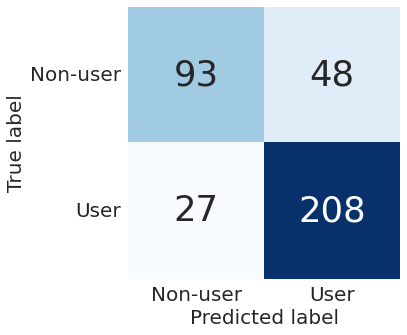





******** SENSITIVITY AND SPECIFICITY CURVES *********


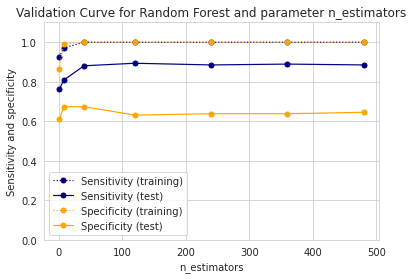

In [ ]:
# 1 - Random Forest

params_rf = {
    'n_estimators': [1, 8, 40, 120, 240, 360, 480], # 1 corresponds to a single decision tree
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20, 30, 50],
    'max_features': [None, 'sqrt'],
    'bootstrap': [True, False]
}

# cross-validation
rf_pipeline = make_pipeline(preprocessing, RandomForestClassifier(n_jobs=-1))
params_rf = adapt_params_to_pipeline(params_rf)
best_rf, best_params_rf = GridSearchCV_routine(rf_pipeline, X_train, y_train, X_test, y_test, params_rf)

# test
test(best_rf, X_test, y_test)

# training and test curves
plot_sen_spc_curves(RandomForestClassifier(criterion='gini',max_features='sqrt',bootstrap=True), 'n_estimators', [1, 8, 40, 120, 240, 360, 480], classifier_name='Random Forest')


******** CV RESULTS ********

    classifier__C classifier__kernel classifier__gamma  \
0           0.001             linear               NaN   
1           0.010             linear               NaN   
2           0.100             linear               NaN   
3           1.000             linear               NaN   
4          10.000             linear               NaN   
..            ...                ...               ...   
58       1000.000                rbf               0.0   
59       1000.000                rbf           0.00002   
60       1000.000                rbf             0.002   
61       1000.000                rbf               0.2   
62       1000.000                rbf                 2   

    sensitivity (micro avg)  specificity (micro avg)  accuracy  
0                  0.789720                 0.788863  0.789474  
1                  0.841321                 0.740214  0.803464  
2                  0.850054                 0.742160  0.808794  
3            

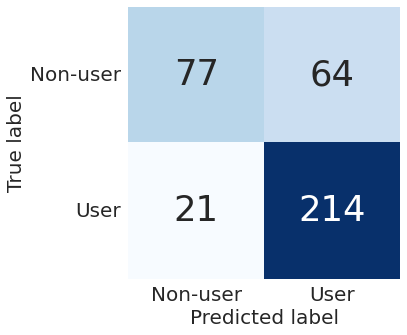





Linear kernel
******** SENSITIVITY AND SPECIFICITY CURVES *********


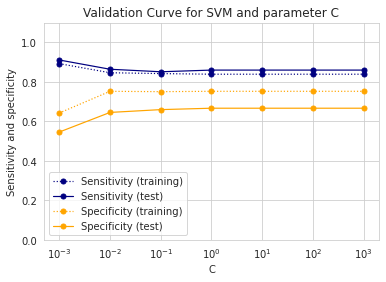

RBF kernel
******** SENSITIVITY AND SPECIFICITY CURVES *********


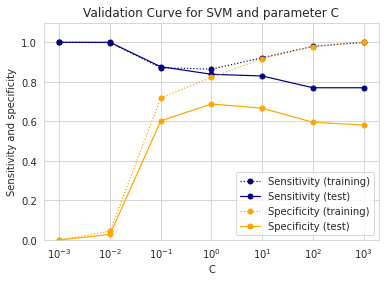

In [ ]:
#2 - SVM

params_svm = [
    {
        'kernel': ['linear'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    },
    {
        'kernel': ['rbf'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'gamma': ['scale','auto', 2e-9, 2e-7, 2e-5, 2e-3, 2e-1, 2]
    }
]

# cross-validation
svm_pipeline = make_pipeline(preprocessing, SVC())
params_svm = adapt_params_to_pipeline(params_svm)
best_svm, best_params_svm = GridSearchCV_routine(svm_pipeline, X_train, y_train, X_test, y_test, params_svm, scoring=confusion_matrix_scores, refit=sen_spc_criterion)

# test
test(best_svm, X_test, y_test)

# training and test curves
print('Linear kernel')
plot_sen_spc_curves(SVC(kernel='linear'), 'C', [0.001, 0.01, 0.1, 1, 10, 100, 1000], classifier_name='SVM', log_scale=True)
print('RBF kernel')
plot_sen_spc_curves(SVC(kernel='rbf',gamma='auto'), 'C', [0.001, 0.01, 0.1, 1, 10, 100, 1000], classifier_name='SVM', log_scale=True)


******** CV RESULTS ********

   classifier__metric  classifier__n_neighbors classifier__weights  \
0           manhattan                        1             uniform   
1           manhattan                        1            distance   
2           manhattan                        3             uniform   
3           manhattan                        3            distance   
4           manhattan                        5             uniform   
5           manhattan                        5            distance   
6           manhattan                        7             uniform   
7           manhattan                        7            distance   
8           manhattan                       10             uniform   
9           manhattan                       10            distance   
10          manhattan                       20             uniform   
11          manhattan                       20            distance   
12          euclidean                        1             u

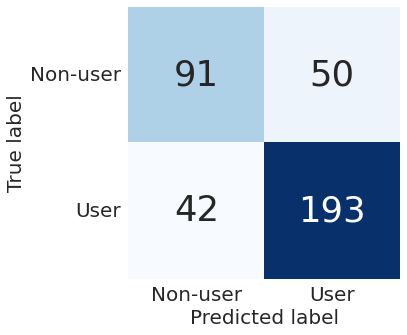





Euclidean distance
******** SENSITIVITY AND SPECIFICITY CURVES *********


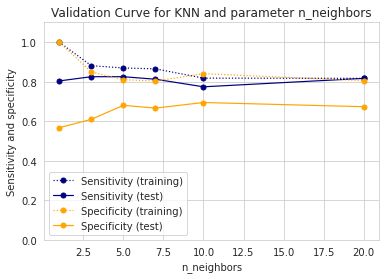

Manhattan distance
******** SENSITIVITY AND SPECIFICITY CURVES *********


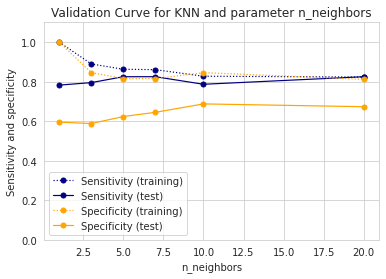

In [ ]:
# 3 - K-Nearest Neighbors

params_knn = {
    'n_neighbors': [1, 3, 5, 7, 10, 20],
    'weights' : ['uniform', 'distance'],
    'metric': ['manhattan', 'euclidean']
}

# cross-validation
knn_pipeline = make_pipeline(preprocessing, KNeighborsClassifier(n_jobs=-1))
params_knn = adapt_params_to_pipeline(params_knn)
best_knn, best_params_knn = GridSearchCV_routine(knn_pipeline, X_train, y_train, X_test, y_test, params_knn)

# test
test(best_knn, X_test, y_test)

# training and test curves
print('Euclidean distance')
plot_sen_spc_curves(KNeighborsClassifier(weights='uniform',metric='euclidean'), 'n_neighbors', [1, 3, 5, 7, 10, 20], classifier_name='KNN')
print('Manhattan distance')
plot_sen_spc_curves(KNeighborsClassifier(weights='uniform',metric='manhattan'), 'n_neighbors', [1, 3, 5, 7, 10, 20], classifier_name='KNN')


******** CV RESULTS ********

   classifier__C  sensitivity (micro avg)  specificity (micro avg)  accuracy
0          0.001                 0.722177                 0.825926  0.740839
1          0.010                 0.823054                 0.761719  0.802132
2          0.100                 0.840168                 0.750909  0.807462
3          1.000                 0.840168                 0.750909  0.807462
4         10.000                 0.841053                 0.751361  0.808128
5        100.000                 0.841053                 0.751361  0.808128
6       1000.000                 0.841053                 0.751361  0.808128

Index of the best estimator: 1
Best parameters: {'classifier__C': 0.01}
Sensitivity, specificity and accuracy of the best estimator on validation: 0.8230535894843276   0.76171875   0.8021319120586277




******** TEST RESULTS *********
         precision recall    f1 support
Non-user     0.744  0.617 0.674     141
User         0.792  0.872 0.830     2

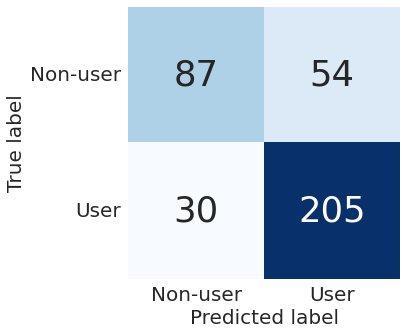





******** SENSITIVITY AND SPECIFICITY CURVES *********


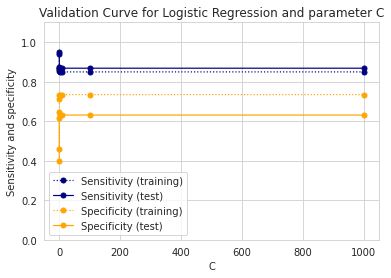

In [ ]:
# 4 - Logistic Regression

params_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}


# cross-validation
lr_pipeline = make_pipeline(preprocessing, LogisticRegression(n_jobs=-1))
params_lr = adapt_params_to_pipeline(params_lr)
best_lr, best_params_lr = GridSearchCV_routine(lr_pipeline, X_train, y_train, X_test, y_test, params_lr)

# test
test(best_lr, X_test, y_test)

# training and test curves
plot_sen_spc_curves(LogisticRegression(), 'C', [0.001, 0.01, 0.1, 1, 10, 100, 1000], classifier_name='Logistic Regression')
